# Работа с временным рядом

#### Данные отображают цены на акции компании WMT на момент их закрытия.

### Загрузка пакетов

In [23]:
import yfinance as yf

import datetime
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
# оценка качества моделей
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit 
from sklearn.metrics import mean_squared_error

# статистические методы
import statsmodels.api as sm
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
# для быстрой обработки пропусков при расчете среднего
from pandas.core.nanops import nanmean as pd_nanmean


# для интерактивного отображения прогресса в расчетах
import tqdm
from tqdm.auto import tqdm

import seaborn as sns
sns.set_theme()

from math import sqrt
import itertools
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

### Загрузка данных

In [24]:
data = yf.Ticker('WMT').history(interval = "1d", start
= '2012-01-01')
data.shape

(2844, 7)

In [25]:
data.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2012-01-03 00:00:00-05:00,46.682620,47.531112,46.604775,46.962856,12668800,0.0,0.0
2012-01-04 00:00:00-05:00,46.869437,46.978417,46.293399,46.480221,9593300,0.0,0.0
2012-01-05 00:00:00-05:00,46.199992,46.410169,45.437128,46.254482,12768200,0.0,0.0
2012-01-06 00:00:00-05:00,46.254484,46.277839,45.826347,45.927544,8069400,0.0,0.0
2012-01-09 00:00:00-05:00,45.950888,46.355673,45.865259,46.067654,6679300,0.0,0.0


Нам нужны только данные о дате и цене закрытия (столбец 'Close').

In [26]:
data = data[['Close']]

In [27]:
data

,Close
Date,
2012-01-03 00:00:00-05:00,46.962856
2012-01-04 00:00:00-05:00,46.480221
2012-01-05 00:00:00-05:00,46.254482
2012-01-06 00:00:00-05:00,45.927544
2012-01-09 00:00:00-05:00,46.067654
...,...
2023-04-17 00:00:00-04:00,149.520004
2023-04-18 00:00:00-04:00,149.850006
2023-04-19 00:00:00-04:00,150.009995


### Построим график временного ряда

<AxesSubplot:title={'center':'Цена на момент закрытия акции'}, xlabel='Date'>

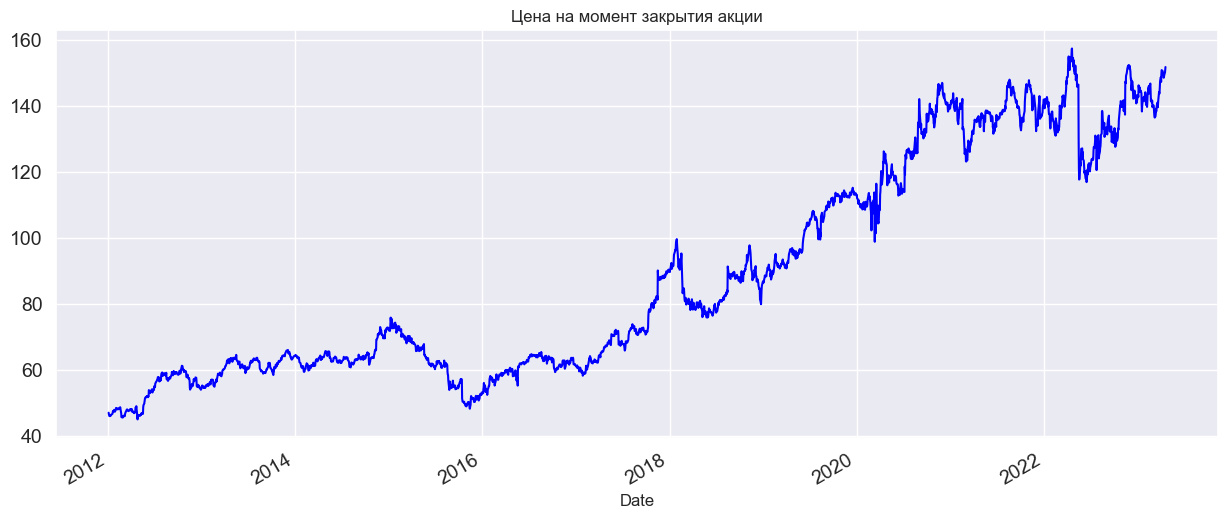

In [28]:
data.Close.plot( figsize=(15,6),title= 'Цена на момент закрытия акции', fontsize=14, color="blue")

График показывает, что цены на акции WMT были в основном стабильны в начале периода. Однако, можно заметить, что существует большое количество короткосрочных колебаний цен, которые не подчиняются общему тренду и вызваны внешними факторами, такими как новости, экономические изменения и т.д.  

На графике цен на момент закрытия акций компании WMT, представленном выше, можно наблюдать общий тренд цен на протяжении всего периода. 

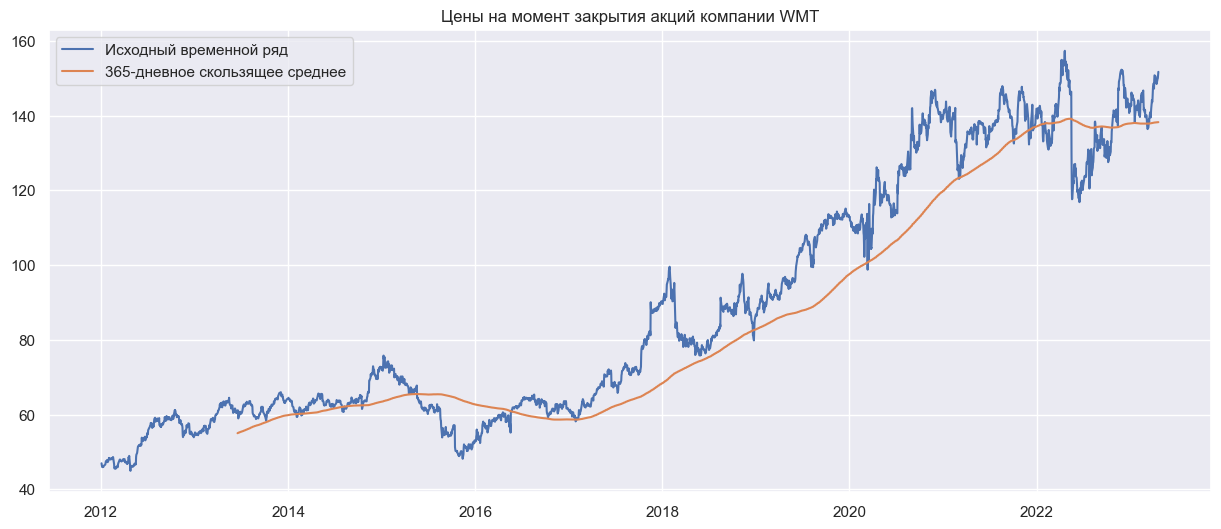

In [29]:
window = 365
rolling_mean = data.Close.rolling(window=window).mean()

plt.figure(figsize=(15,6))
plt.plot(data.Close, label='Исходный временной ряд')
plt.plot(rolling_mean, label='365-дневное скользящее среднее')
plt.legend(loc='best')
plt.title('Цены на момент закрытия акций компании WMT')
plt.show()


### Тест Дикки-Фуллера 

Проверим на уровне значимости 0.05

In [30]:
def test_stationarity(timeseries, window = 24, cutoff = 0.05):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(15, 4))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    
    plt.show()
    
    #Perform Dickey-Fuller test:
    # p-value
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries.values,autolag='AIC' )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)

In [31]:
sample_data = data.Close

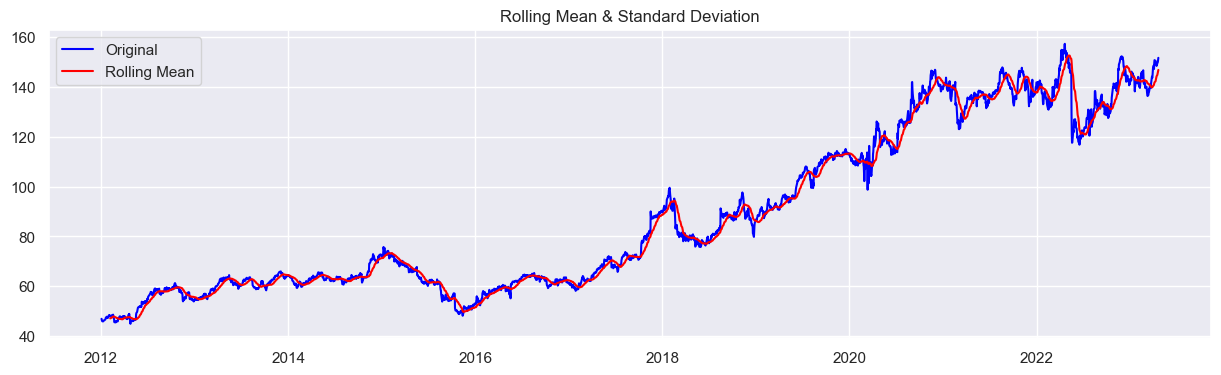

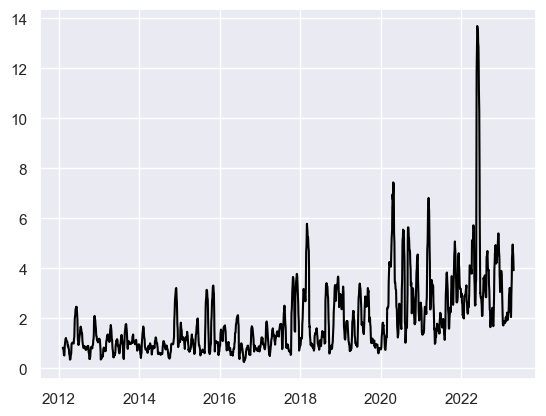

Results of Dickey-Fuller Test:
p-value = 0.9255. The series is likely non-stationary.
Test Statistic                   -0.300115
p-value                           0.925488
#Lags Used                       22.000000
Number of Observations Used    2821.000000
Critical Value (1%)              -3.432670
Critical Value (5%)              -2.862565
Critical Value (10%)             -2.567316
dtype: float64


In [32]:
test_stationarity(sample_data)

На основании теста Dickey-Fuller, можно сделать вывод о том, что временной ряд не является стационарным. Это подтверждается большим значением p-value, превышающим уровень значимости 0.05, и недостаточным значением тестовой статистики для отклонения от нулевой гипотезы о нестационарности ряда.

### Методология Бокса-Дженкинса.

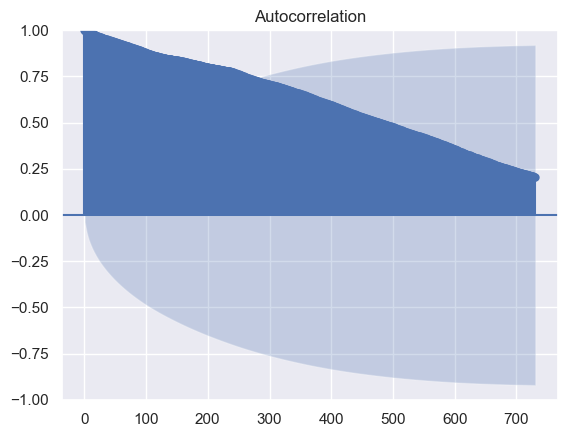

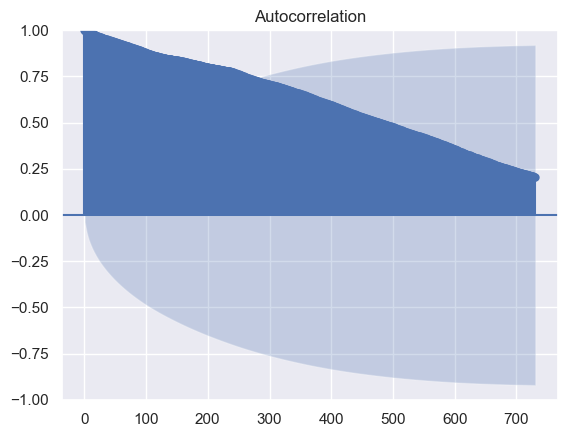

In [33]:
plot_acf(data.Close, lags=730)


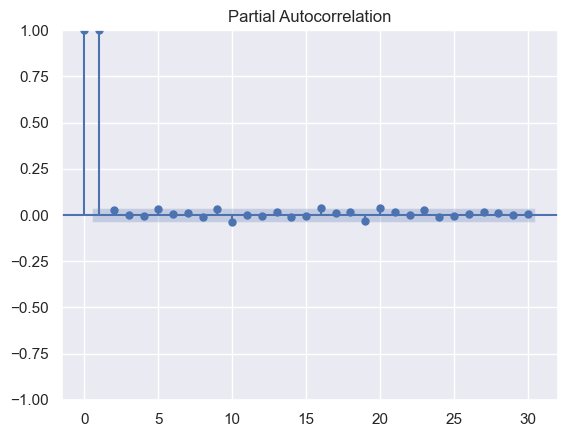

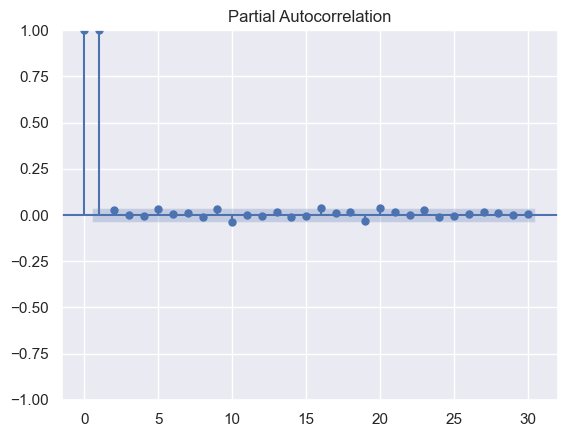

In [34]:
plot_pacf(data.Close, lags=30)

Это означает, что на 290 лаге автокорреляционная функция (ACF) последующие лаги становятся значимыми. Из графика PACF (Partial Autocorrelation Function) можно сделать вывод, что после второго лага все последующие лаги не являются значимыми, т.е. корреляция становится незначительной. 

Результаты построение PACF и ACF не удовлетворительны. Сложно определить примерные значения p,q для построения ARIMA-модели.
Предлагается для начала избавится от трендовой зависимости

### Удаления линейной трендовой составляющей из временного ряда

In [35]:
data["indexs"] = range(1, len(data)+1, 1)
from sklearn.linear_model import LinearRegression

X = np.array(data["indexs"]).reshape((-1, 1))
Y = np.array(data["Close"])

model = LinearRegression().fit(X,Y)
print('Y=', model.coef_[0], '*X +', model.intercept_)
print('coefficient of determination:', model.score(X, Y))
data["Close_t"] = data["Close"] - (data["indexs"] * model.coef_[0] + model.intercept_)
data

Y= 0.03681965292355227 *X + 36.08714127113647
coefficient of determination: 0.8523196617165694


,Close,indexs,Close_t
Date,,,
2012-01-03 00:00:00-05:00,46.962856,1,10.838895
2012-01-04 00:00:00-05:00,46.480221,2,10.319440
2012-01-05 00:00:00-05:00,46.254482,3,10.056882
2012-01-06 00:00:00-05:00,45.927544,4,9.693124
2012-01-09 00:00:00-05:00,46.067654,5,9.796414
...,...,...,...
2023-04-17 00:00:00-04:00,149.520004,2840,8.865049
2023-04-18 00:00:00-04:00,149.850006,2841,9.158231
2023-04-19 00:00:00-04:00,150.009995,2842,9.281400


<AxesSubplot:title={'center':'Цены на момент закрытия акций компании WMT без тренда'}, xlabel='Date'>

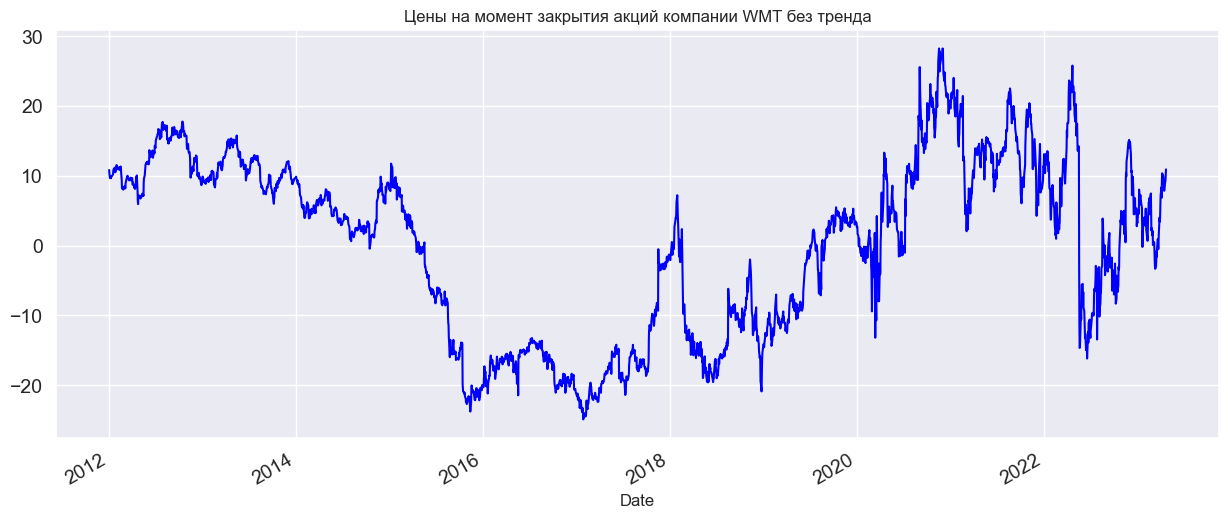

In [36]:
data.Close_t.plot( figsize=(15,6),title= 'Цены на момент закрытия акций компании WMT без тренда', fontsize=14, color="blue")

### Тест Дикки-Фуллера  без тренда

In [37]:
dftest_t = adfuller(data.Close_t,autolag='AIC')

if dftest_t[1] < 0.05:
    print('p-value = %.4f. The series is likely stationary.' % dftest_t[1])
else:
    print('p-value = %.4f. The series is likely non-stationary.' % dftest_t[1])


p-value = 0.1542. The series is likely non-stationary.


Хоть ряд и не является стационарным, результаты теста Дики-Фуллера показывают, что значение p-value уменьшилось. Это может свидетельствовать о том, что ряд стал более стационарным, чем раньше. 

### Методология Бокса-Дженкинса без тренда

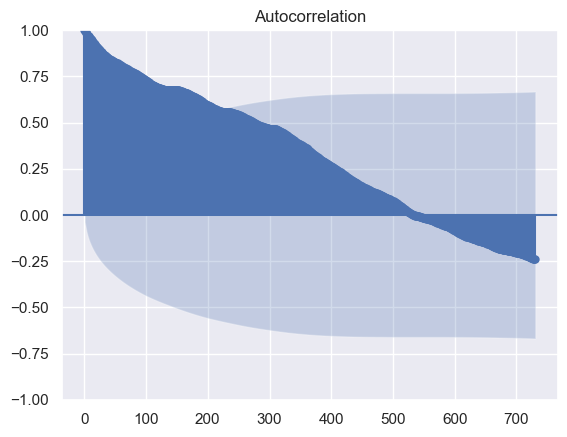

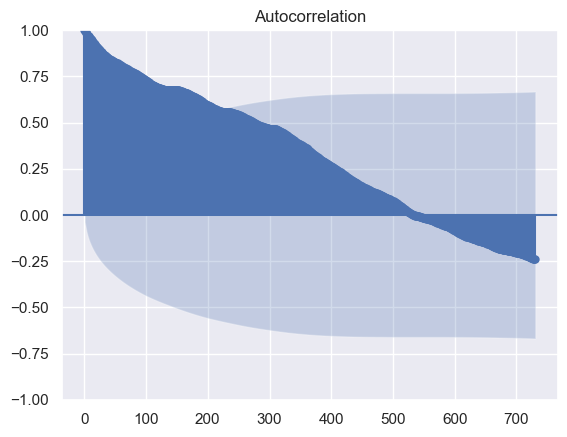

In [38]:
plot_acf(data.Close_t, lags=730)

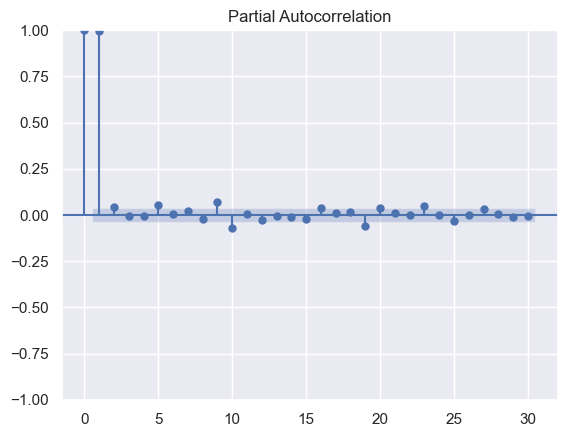

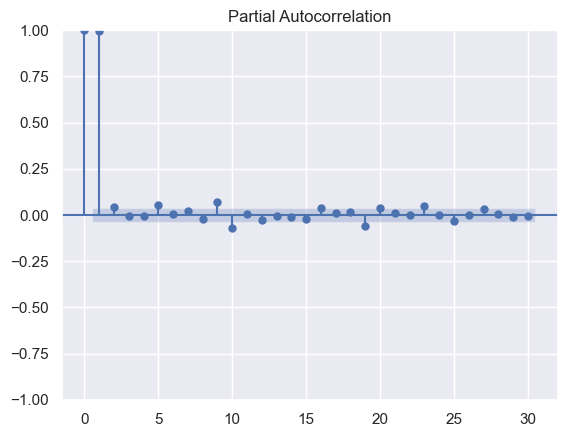

In [39]:
plot_pacf(data.Close_t, lags=30)

Мы смогли снизить зависимость цены акции от предыдущих значений, однако она все еще остается существенной.

### Разделяем на обучающую и тестовую выборки

In [40]:
from sklearn. model_selection import train_test_split
# Разделение выборки на обучающую и тестовую
train, test = data[0:2556], data[2556:]


# Проверка размеров выборок
print(f"Размер обучающей выборки: {train.shape[0]}")
print(f"Размер тестовой выборки: {test.shape[0]}")



Размер обучающей выборки: 2556
Размер тестовой выборки: 288


<AxesSubplot:title={'center':'Цена на момент закрытия акции'}, xlabel='Date'>

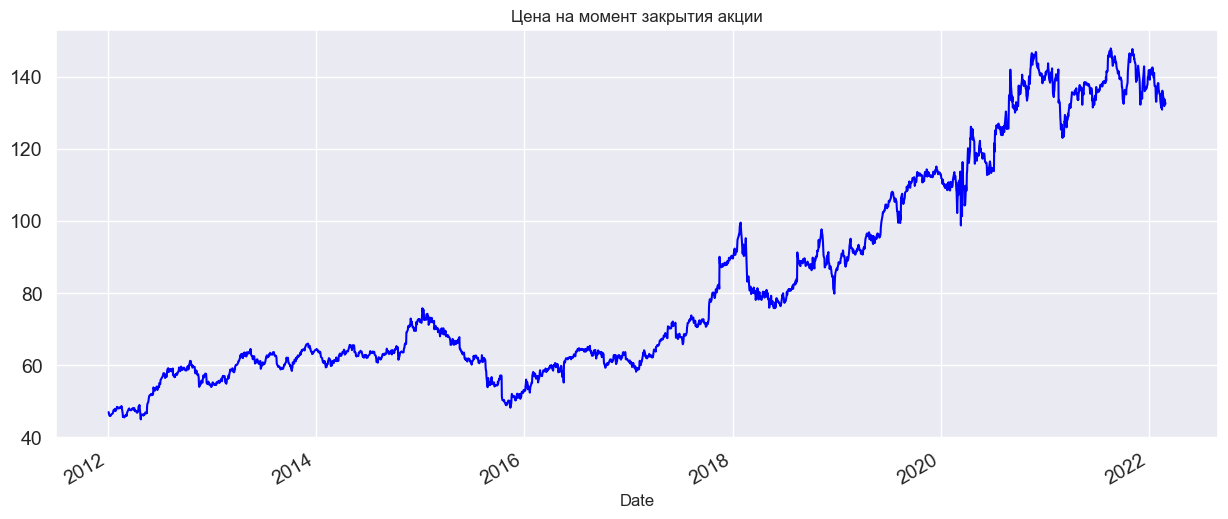

In [41]:
train.Close.plot( figsize=(15,6),title= 'Цена на момент закрытия акции', fontsize=14, color="blue")

In [42]:
p = range(0,8)
d = range(0,3)
q = range(0,15)
pdq = list(itertools.product(p, d, q))
best_params = (0,0,0)
best_AIC = np.inf

for params in tqdm(pdq):
    
    model_test = sm.tsa.arima.ARIMA(train.Close_t, order = params)
    result_test = model_test.fit()
    if result_test.aic < best_AIC:
        best_params = params
        best_AIC = result_test.aic
print(best_params, best_AIC)

100%|██████████| 360/360 [40:40<00:00,  6.78s/it]  

(7, 1, 6) 7772.518964567455


In [43]:
p = range(0,8)
d = range(0,3)
q = range(0,15)
pdq = list(itertools.product(p, d, q))
best_params = (0,0,0)
best_AIC = np.inf

for params in tqdm(pdq):
    
    model_test = sm.tsa.arima.ARIMA(train.Close, order = params)
    result_test = model_test.fit()
    if result_test.aic < best_AIC:
        best_params = params
        best_AIC = result_test.aic
print(best_params, best_AIC)

100%|██████████| 360/360 [54:42<00:00,  9.12s/it]  

(7, 1, 6) 7774.685376103844


Исходя из полученных результатов, можно сделать вывод, что модель ARIMA(7,1,6), которая учитывает тренд, дает более точные прогнозы, чем модель ARIMA(7,1,6) без тренда. Это можно объяснить тем, что в исходных данных присутствует заметный тренд, и учет тренда позволяет лучше описать структуру временного ряда.

### Проверим модель на тестовой выборке

In [44]:
test.Close

Date
2022-03-01 00:00:00-05:00    133.338913
2022-03-02 00:00:00-05:00    133.505600
2022-03-03 00:00:00-05:00    136.574570
2022-03-04 00:00:00-05:00    140.035751
2022-03-07 00:00:00-05:00    138.908188
                                ...    
2023-04-17 00:00:00-04:00    149.520004
2023-04-18 00:00:00-04:00    149.850006
2023-04-19 00:00:00-04:00    150.009995
2023-04-20 00:00:00-04:00    150.970001
2023-04-21 00:00:00-04:00    151.729996
Name: Close, Length: 288, dtype: float64

In [45]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [46]:
model_test = sm.tsa.arima.ARIMA(test.Close, order = (7,2,8))
result_test = model_test.fit()
preds = result_test.predict(dynamic=False)

print(mean_absolute_percentage_error(test.Close, preds))

1.6176829301013458


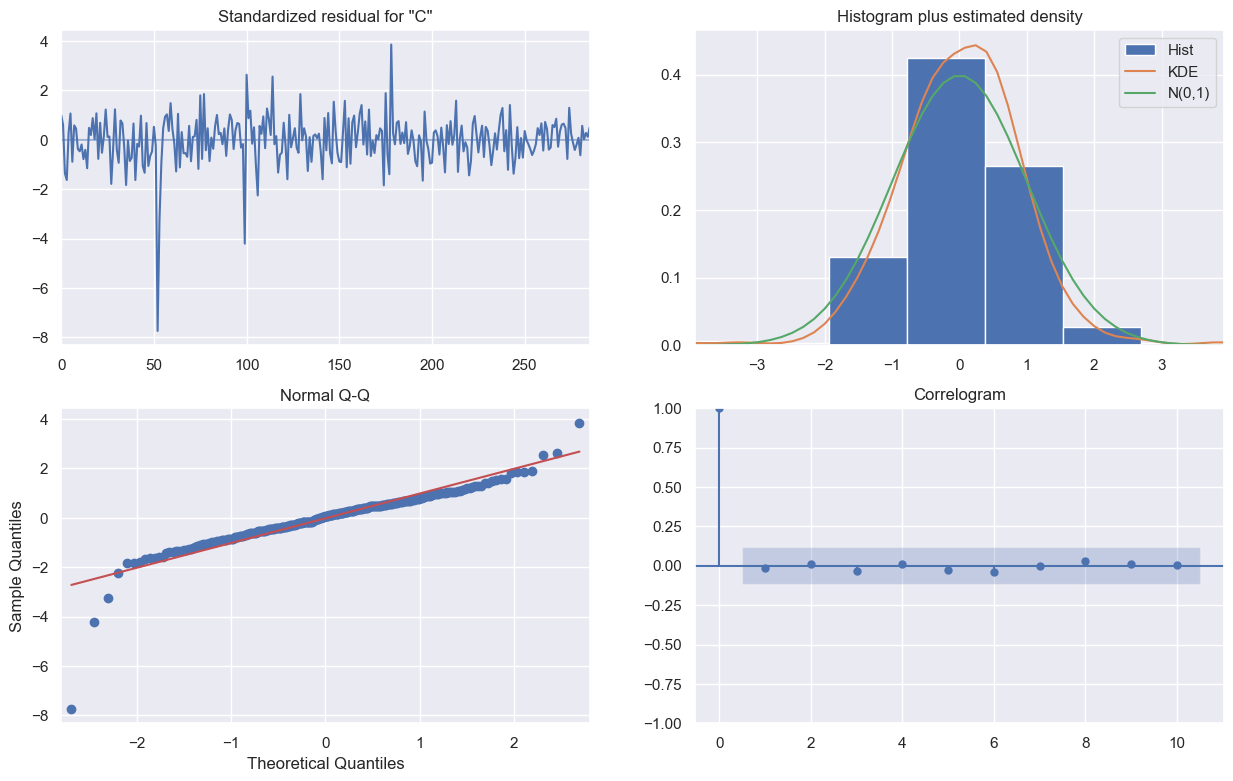

In [47]:
result_test.plot_diagnostics(figsize=(15, 9))
plt.show()

### Построим прогноз

In [69]:
# Получить прогноз на 10 шагов вперёд
pred_uc = result_test.get_forecast(steps=10)
# Получить интервал прогноза
pred_ci = pred_uc.conf_int()

In [70]:
y = pd.Series(test.Close, index=test.index)
y

Date
2022-03-01 00:00:00-05:00    133.338913
2022-03-02 00:00:00-05:00    133.505600
2022-03-03 00:00:00-05:00    136.574570
2022-03-04 00:00:00-05:00    140.035751
2022-03-07 00:00:00-05:00    138.908188
                                ...    
2023-04-17 00:00:00-04:00    149.520004
2023-04-18 00:00:00-04:00    149.850006
2023-04-19 00:00:00-04:00    150.009995
2023-04-20 00:00:00-04:00    150.970001
2023-04-21 00:00:00-04:00    151.729996
Name: Close, Length: 288, dtype: float64

In [71]:
dti = pd.date_range("2023-04-23 00:00:00-04:00", periods=10, freq="1D")
dti

DatetimeIndex(['2023-04-23 00:00:00-04:00', '2023-04-24 00:00:00-04:00',
               '2023-04-25 00:00:00-04:00', '2023-04-26 00:00:00-04:00',
               '2023-04-27 00:00:00-04:00', '2023-04-28 00:00:00-04:00',
               '2023-04-29 00:00:00-04:00', '2023-04-30 00:00:00-04:00',
               '2023-05-01 00:00:00-04:00', '2023-05-02 00:00:00-04:00'],
              dtype='datetime64[ns, pytz.FixedOffset(-240)]', freq='D')

In [72]:
y_pred_mean = pred_uc.predicted_mean
df = pd.DataFrame(y_pred_mean)
df = df.to_numpy()
print(df[:,0])
y_pred_mean_dti = pd.Series(data=df[:,0],index=dti)
y_pred_mean_dti.index.names = ['Date']
y_pred_mean_dti
type(y_pred_mean_dti)

[152.06981029 152.03936845 152.40675724 152.31668065 152.17713614
 152.57127115 152.45710014 152.63745026 152.40726869 152.88258683]


pandas.core.series.Series

In [73]:
y_pred = pred_ci.set_index(dti)
y_pred.index.names = ['Date']
y_pred
type(y_pred)

pandas.core.frame.DataFrame

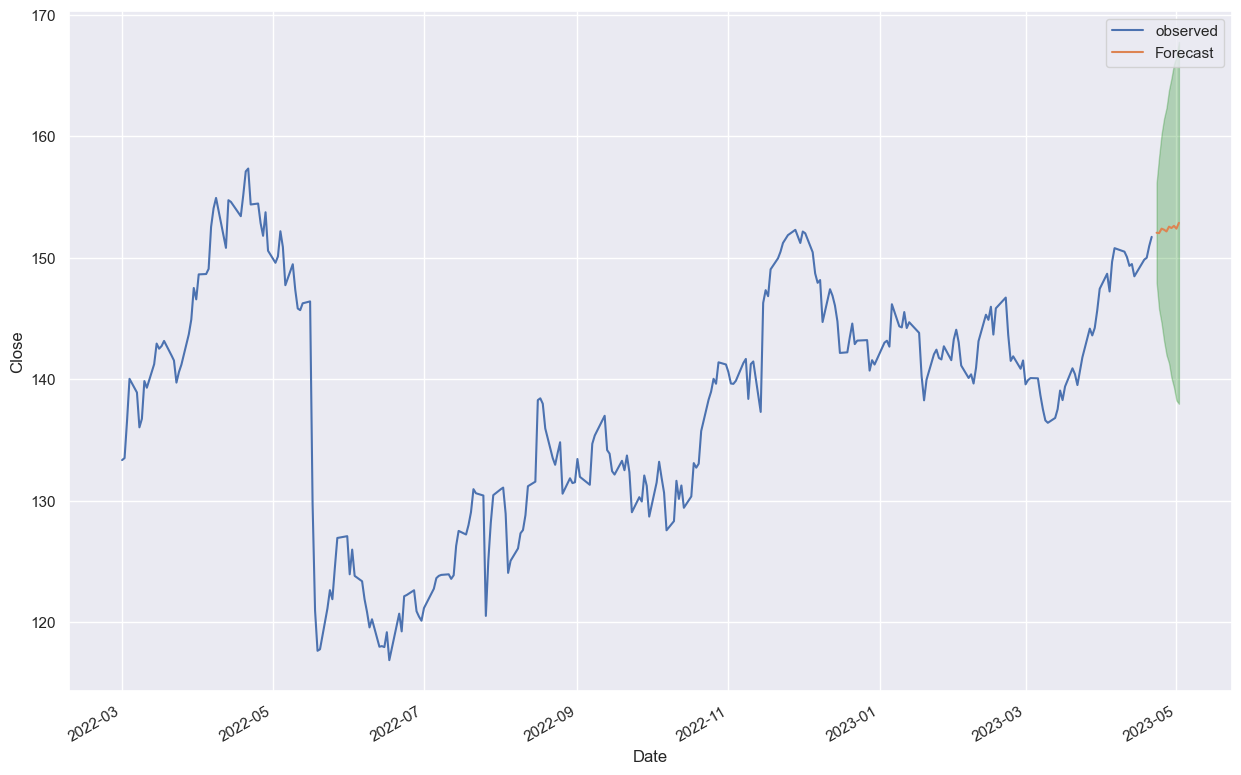

In [74]:
ax = y.plot(label='observed', figsize=(15, 10))
y_pred_mean_dti.plot(ax=ax, label='Forecast')
ax.fill_between(y_pred.index,
y_pred.iloc[:, 0],
y_pred.iloc[:, 1], color='green', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Close')
plt.legend()
plt.show()

Исходя из анализа графика, можно сделать вывод, что в будущем цены на акции компании WMT скорее всего будут повышаться.

### Построение моделей для прогноза по разным периодам

In [54]:
data = yf.Ticker('WMT').history(interval = "1d", start
= '2012-01-01')
data.shape

(2844, 7)

<AxesSubplot:title={'center':'Цена закрытия акции'}, xlabel='Date'>

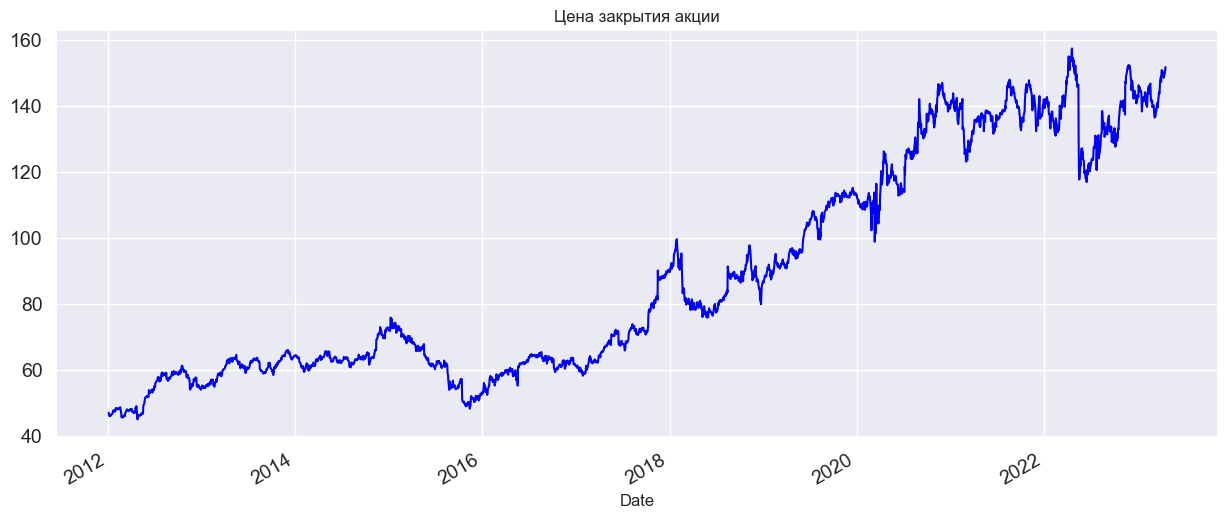

In [55]:
data.Close.plot( figsize=(15,6),title= 'Цена закрытия акции', fontsize=14, color="blue")

### Требуется разделить исходные данные на 3 блока:

1) До апреля 2015

2) апрель 2015 - начало 2019

3) начало 2019 - н.в.

In [56]:
data_1 = data.index < '2015-04-01 00:00:00-04:00'
data_1 = data.loc[data_1]
data_1

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2012-01-03 00:00:00-05:00,46.682624,47.531116,46.604779,46.962860,12668800,0.0,0.0
2012-01-04 00:00:00-05:00,46.869445,46.978425,46.293406,46.480228,9593300,0.0,0.0
2012-01-05 00:00:00-05:00,46.200004,46.410181,45.437140,46.254494,12768200,0.0,0.0
2012-01-06 00:00:00-05:00,46.254469,46.277824,45.826331,45.927528,8069400,0.0,0.0
2012-01-09 00:00:00-05:00,45.950903,46.355688,45.865275,46.067669,6679300,0.0,0.0
...,...,...,...,...,...,...,...
2015-03-25 00:00:00-04:00,70.022109,70.156949,68.522058,68.530487,6645900,0.0,0.0
2015-03-26 00:00:00-04:00,68.201848,69.364808,67.965885,69.010864,8267200,0.0,0.0
2015-03-27 00:00:00-04:00,68.977134,69.255235,68.471500,68.555771,5717400,0.0,0.0


In [57]:
data_2 = data.query("index >= '2015-04-01 00:00:00-04:00' & index < '2019-01-01 00:00:00-04:00'")
data_2

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2015-04-01 00:00:00-04:00,69.339521,69.339521,67.780479,68.016441,8306700,0.0,0.0
2015-04-02 00:00:00-04:00,68.033272,68.530477,67.881581,68.033272,5795700,0.0,0.0
2015-04-06 00:00:00-04:00,67.805774,68.538949,67.544531,68.252419,6380700,0.0,0.0
2015-04-07 00:00:00-04:00,68.336691,68.505240,67.805775,67.839485,6606100,0.0,0.0
2015-04-08 00:00:00-04:00,67.746743,68.454636,67.721462,68.286087,6694700,0.0,0.0
...,...,...,...,...,...,...,...
2018-12-24 00:00:00-05:00,80.522475,81.480853,79.815320,79.852539,6110300,0.0,0.0
2018-12-26 00:00:00-05:00,80.410813,84.132674,80.299162,84.123375,10028300,0.0,0.0
2018-12-27 00:00:00-05:00,83.509253,85.239919,82.290346,85.221306,9881500,0.0,0.0


In [58]:
data_3 = data.query("index > '2019-01-01 00:00:00-04:00'")
data_3

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2019-01-02 00:00:00-05:00,85.267837,87.138074,85.267837,86.849625,8152700,0.0,0.0
2019-01-03 00:00:00-05:00,86.728684,88.124382,86.254145,86.403023,8277300,0.0,0.0
2019-01-04 00:00:00-05:00,86.728693,87.147407,86.244854,86.942703,8029100,0.0,0.0
2019-01-07 00:00:00-05:00,87.110175,88.552392,86.700768,87.966202,7789700,0.0,0.0
2019-01-08 00:00:00-05:00,88.450035,89.101365,87.380005,88.580299,7200900,0.0,0.0
...,...,...,...,...,...,...,...
2023-04-17 00:00:00-04:00,148.639999,149.669998,148.500000,149.520004,5388900,0.0,0.0
2023-04-18 00:00:00-04:00,149.779999,150.339996,149.440002,149.850006,4494100,0.0,0.0
2023-04-19 00:00:00-04:00,150.839996,151.410004,149.770004,150.009995,4144500,0.0,0.0


### Разделим выборку на тестовую и обучающую

In [59]:
train_1, test_1 = data_1[0:733], data_1[733:]
train_2, test_2 = data_2[0:850], data_2[850:]
train_3, test_3 = data_3[0:975], data_3[975:]

In [60]:
p = range(0, 5)
d = range(0, 5)
q = range(0, 10)
pdq = list(itertools.product(p, d, q))

best_params = (0, 0, 0)
best_aic = np.inf

for params in tqdm(pdq):
    try:
        model = sm.tsa.arima.ARIMA(train_1.Close, order=params)
        result = model.fit()
        if result.aic < best_aic:
            best_params = params
            best_aic = result.aic
    except:
        continue

model = sm.tsa.arima.ARIMA(test_1.Close, order=best_params)
result = model.fit()
print('Best model on 1 block:', best_params, 'AIC on train:', best_aic, 'AIC on test:', result.aic)


100%|██████████| 250/250 [04:52<00:00,  1.17s/it]

Best model on 1 block: (0, 1, 0) AIC on train: 1109.2042955126117 AIC on test: 200.07060238599345


In [61]:
p = range(0, 5)
d = range(0, 5)
q = range(0, 10)
pdq = list(itertools.product(p, d, q))

best_params = (0, 0, 0)
best_aic = np.inf

for params in tqdm(pdq):
    try:
        model = sm.tsa.arima.ARIMA(train_2.Close, order=params)
        result = model.fit()
        if result.aic < best_aic:
            best_params = params
            best_aic = result.aic
    except:
        continue

model = sm.tsa.arima.ARIMA(test_2.Close, order=best_params)
result = model.fit()
print('Best model on 2 block:', best_params, 'AIC on train:', best_aic, 'AIC on test:', result.aic)


100%|██████████| 250/250 [05:20<00:00,  1.28s/it]


Best model on 2 block: (4, 1, 4) AIC on train: 2210.0145177978775 AIC on test: 340.9555469843026


In [62]:
p = range(0, 5)
d = range(0, 5)
q = range(0, 10)
pdq = list(itertools.product(p, d, q))

best_params = (0, 0, 0)
best_aic = np.inf

for params in tqdm(pdq):
    try:
        model = sm.tsa.arima.ARIMA(train_3.Close, order=params)
        result = model.fit()
        if result.aic < best_aic:
            best_params = params
            best_aic = result.aic
    except:
        continue

model = sm.tsa.arima.ARIMA(test_3.Close, order=best_params)
result = model.fit()
print('Best model on 3 block:', best_params, 'AIC on train:', best_aic, 'AIC on test:', result.aic)


100%|██████████| 250/250 [06:14<00:00,  1.50s/it]


Best model on 3 block: (2, 1, 6) AIC on train: 3908.2894364110707 AIC on test: 423.07781087883956


Из результатов моделирования видно, что лучшая модель на первом блоке данных имеет порядок (0,1,0) и достигает AIC на тренировочной выборке в размере 1109.20, а на тестовой - 200.07. Лучшая модель на втором блоке данных имеет порядок (4,1,4) и достигает AIC на тренировочной выборке в размере 2210.01, а на тестовой - 340.95. Лучшая модель на третьем блоке данных имеет порядок (2,1,6) и достигает AIC на тренировочной выборке в размере 3908.29, а на тестовой - 423.07.

Модель с наименьшим значением AIC на тестовой выборке является наиболее предпочтительной для прогнозирования будущих значений. Следовательно, на основе результатов моделирования можно сделать вывод, что наиболее точная модель на тестовой выборке была построена на первом блоке данных и имеет порядок (0,1,0).